In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
import seaborn as sns
from hmmlearn.hmm import MultinomialHMM
import yfinance as yf
from sklearn.model_selection import train_test_split

In [3]:
def portfolio_return (weight, returns): 
    return weight.T @ returns

def portfolio_vol(weight, cov):
    return (weight.T @ cov @ weight)**0.5

def plot_ef_2(n_points, er, cov, style=".-"):
    """Plots the 2-asset efficient frontier
    """
    weights = [np.array([w,1-w])for w in np.linspace(0,1,n_points)]
    rets=[portfolio_return(w,er)for w in weights]
    vols=[portfolio_vol(w,cov) for w in weights]
    ef=pd.DataFrame({"Returns":rets, "Volatility":vols})
    return ef.plot.line(x="Volatility", y="Returns", style=style)

def target_is_met(w,er):
    return target_return - portfolio_return(w,er)

def minimize_vol(target_return, er, cov):
    """ Target return --> Weight vector
    """
    n=er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    return_is_target = {
        'type':'eq',
        'args':(er,),
        'fun': lambda weights, er : target_return - portfolio_return(weights,er)
    }
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    results = minimize(portfolio_vol, init_guess, args=(cov,), method='SLSQP', options={'disp' : False},
                       constraints=(return_is_target, weights_sum_to_1), bounds=bounds)
    return results.x

def optimal_weights(n_points, er, cov):
    """list of weihgts to run the optimizer on to minimize the vol
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights=[minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def msr (riskfree_rate, er, cov):
    """Returns the weights of the portfolio that gives you the maximum sharpe ratio 
    given the riskfree rate and expected returns and a covariance matrix
    """
    n=er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),)*n
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights: np.sum(weights)-1
    }
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """Returns the negative of the sharpe ratio, given weights
        """
        r=portfolio_return(weights, er)
        vol=portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, init_guess, args=(riskfree_rate, er, cov,), method='SLSQP',
                       options={'disp' : False},
                       constraints=(weights_sum_to_1), bounds=bounds)
    return results.x

def gmv(cov):
    """Returns the weights of the Global Minimum Vol portfolio
    given the covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1,n), cov)
    
def plot_ef(n_points, er, cov, show_cml=False, style='.-', riskfree_rate=0, show_ew=False, show_gmv=False):
    """Plots the N-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets=[portfolio_return(w,er)for w in weights]
    vols=[portfolio_vol(w,cov)for w in weights]
    ef=pd.DataFrame({"Returns":rets, "Volatility":vols})
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=True)
    if show_ew:
        n=er.shape[0]
        w_ew = np.repeat(1/n,n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        ax.plot([vol_ew], [r_ew], color="goldenrod", marker="o", markersize=10, label="EW")
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        ax.plot([vol_gmv], [r_gmv], color="midnightblue", marker="o", markersize=10, label="GMV")
    if show_cml:
        ax.set_xlim(left = 0)
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', markersize=10, linewidth=2, label="CML")
    ax.legend()
    plt.show()


In [ ]:
def get_returns(n):
    rets = np.random.uniform(0, 1, n)
    return rets

def get_cov(n):
    A = np.random.normal(0, 1, (n, n))
    S = A @ A.T
    D = np.diag(1/np.sqrt(np.diag(S)))
    correlation_matrix = D @ S @ D
    np.fill_diagonal(correlation_matrix, 1)
    return correlation_matrix

In [20]:
n=8
rets = get_returns(n)
cov = get_cov(n)

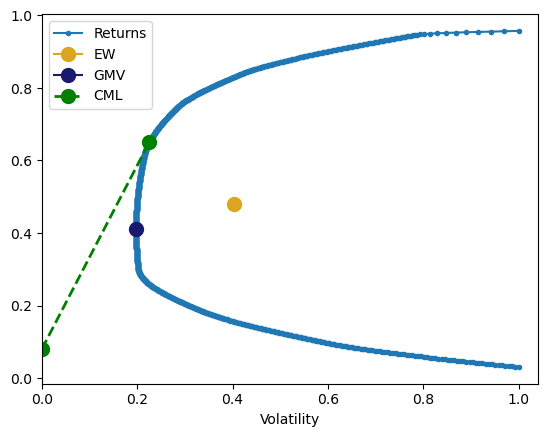

In [24]:
plot_ef(1000, rets, cov, show_cml=True, show_ew=True, show_gmv=True, riskfree_rate=0.08)

### HMM

In [30]:
start_prob = np.array([0.5, 0.5])
trans_mat = np.array([[0.7, 0.3], [0.3, 0.7]])
cov = np.array([[0.9, 0.1], [0.2, 0.8]])

model = MultinomialHMM(n_components=2, startprob_prior=start_prob, transmat_prior=trans_mat)
X = [[0, 0, 1, 0], [0, 0, 0, 0], [1, 1, 1, 0], [0, 0, 1, 0]]
model.fit(X)
model.transmat_

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


array([[nan, nan],
       [nan, nan]])

In [110]:
prices = yf.download('AAPL', start='2020-01-01')['Adj Close']
returns = prices.pct_change().dropna().values
returns

[*********************100%%**********************]  1 of 1 completed


array([-0.00972203,  0.00796814, -0.00470283, ...,  0.01610115,
        0.00413376, -0.00516608])

In [85]:
# Split into train and test data
n = len(returns)
returns_train = returns[:round(0.95*n)]
returns_test = returns[round(0.95*n)+1:]

In [89]:
# Define different states
tresholds = np.percentile(returns_train, [33, 66])
states = np.zeros_like(returns_train)

states[returns_train<tresholds[0]] = 0  # First state
states[(returns_train>tresholds[0]) & (returns_train<tresholds[1])] = 1  # Second state
states[returns_train>tresholds[1]] = 2  # Third state
states = states.astype(int)

In [ ]:
# Define Transition matrix
n_states = 3

transmat = np.zeros((n_states, n_states))

for i in range(0, len(states)-1):
    current_state = states[i]
    next_state = states[i+1]
    transmat[current_state, next_state] += 1

transmat = transmat / transmat.sum(axis=1, keepdims=True)  # On somme par ligne
transmat = np.nan_to_num(transmat)   # Si un état n'est pas observé du tout
transmat

array([[0.34615385, 0.30512821, 0.34871795],
       [0.31876607, 0.33676093, 0.34447301],
       [0.32338308, 0.34825871, 0.32835821]])

In [ ]:
# Build the model
model = MultinomialHMM(n_components=3, random_state=42)
states = states.reshape(-1, 1)
model.fit(states)
model.startprob_ = [1/3, 1/3, 1/3]
model.transmat_ = transmat
model.n_trials = 1

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [93]:
# Test and predict hidden states with the model

n_steps = 10
returns_test = returns_test.reshape(-1, 1).astype(int)
predictions = model.predict(returns_test)
pred_proba = model.predict_proba(returns_test)
likelihood = model.score(returns_test)
sample_obs, sample_states = model.sample(n_steps)

In [94]:
likelihood

nan

In [98]:
states_test = np.zeros_like(returns_test)
states_test[returns_test<tresholds[0]] = 0  # First state
states_test[(returns_test>tresholds[0]) & (returns_test<tresholds[1])] = 1  # Second state
states_test[returns_test>tresholds[1]] = 2  # Third state

In [123]:
def hmm_model (series, n_states):
    """ 
    series : Sequence of observations. Should be a list
    n_states : Number of hidden states
    """
    # Split into train and test data
    n = len(series)
    train_series = series[:round(0.8*n)]
    test_series = series[round(0.8*n)+1:]

    # Define different states
    quantiles = np.linspace(0, 1, n_states+1)
    quantiles = quantiles[1:-1]*100
    tresholds = np.percentile(train_series, quantiles)
    states = np.zeros_like(train_series)

    states[train_series<tresholds[0]] = 0   # First state

    if n_states > 2:
        for i in range (1, n_states-1):
            states[(train_series>tresholds[i-1]) & (train_series<tresholds[i])] = i   # i-ième state

    states[train_series>tresholds[-1]] = n_states - 1   # Last state
    states = states.astype(int)

    # Define Transition matrix
    transmat = np.zeros((n_states, n_states))

    for i in range(0, len(states)-1):
        current_state = states[i]
        next_state = states[i+1]
        transmat[current_state, next_state] += 1

    transmat = transmat / transmat.sum(axis=1, keepdims=True)  # On somme par ligne
    transmat = np.nan_to_num(transmat)   # Si un état n'est pas observé du tout

    # Build the model
    model = MultinomialHMM(n_components=n_states, random_state=42)
    states = states.reshape(-1, 1)
    model.fit(states)
    model.startprob_ = np.repeat(1/n_states, n_states)
    model.transmat_ = transmat
    model.n_trials = 1

    return model, transmat

In [112]:
prices = yf.download('AAPL', start='2020-01-01')['Adj Close']
returns = prices.pct_change().dropna().values

[*********************100%%**********************]  1 of 1 completed


In [125]:
hmm_model(returns, 5)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


(MultinomialHMM(n_components=5, n_trials=1,
                random_state=RandomState(MT19937) at 0x1F6F5798A40),
 array([[0.26633166, 0.14070352, 0.1959799 , 0.18592965, 0.21105528],
        [0.15577889, 0.18090452, 0.21105528, 0.20100503, 0.25125628],
        [0.15656566, 0.24242424, 0.19191919, 0.21717172, 0.19191919],
        [0.1758794 , 0.24623116, 0.1959799 , 0.22110553, 0.16080402],
        [0.24623116, 0.18592965, 0.20603015, 0.1758794 , 0.18592965]]))